Libraries

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, Flatten, Dropout, Dense, Reshape, Conv2DTranspose, RandomFlip, RandomRotation, RandomZoom, RandomBrightness
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras import models
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow as tf
from tensorflow.keras.utils import array_to_img
import random
import os
import glob
from PIL import Image
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load Dataset

In [ ]:
dataDir = 'drive/MyDrive/machinelearning/extract/TM-A_Chassis_Single/'

Data Normalization

In [ ]:
batch_size = 32
dataset = image_dataset_from_directory(
    dataDir, labels='inferred', label_mode='categorical', image_size=(64, 64), batch_size=batch_size
)
x_train = dataset.map(lambda x, y: x / 255.0)
y_train = dataset.map(lambda x, y: y)

Found 190 files belonging to 10 classes.


Create Model

In [ ]:
discriminator = Sequential(
    [
        Input(shape=(64, 64, 3)),
        Conv2D(64, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2D(128, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2D(128, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Flatten(),
        Dropout(0.2),
        Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

In [ ]:
latent_dim = 128
generator = Sequential(
    [
        Input(shape=(latent_dim,)),
        Dense(8 * 8 * 128),
        Reshape((8, 8, 128)),
        Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

GAN

In [ ]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile1(self, d_optimizer, g_optimizer, loss_fn):
        # super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        
        generated_images = self.generator(random_latent_vectors)

        
        combined_images = tf.concat([generated_images, real_images], axis=0)

        
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        
        misleading_labels = tf.zeros((batch_size, 1))

       
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

GAN Training

In [ ]:
from keras.engine.training import optimizer
epochs = 10 

gan = GAN(discriminator=discriminator,generator=generator,latent_dim=latent_dim)

gan.compile1(
    d_optimizer=Adam(learning_rate=0.0001),
    g_optimizer=Adam(learning_rate=0.0001),
    loss_fn=BinaryCrossentropy()
)

In [ ]:
epochs = 50
gan.compile(optimizer=Adam(learning_rate=0.0001),loss=BinaryCrossentropy())
history = gan.fit(
    x_train, epochs=epochs
)

n_trained_epochs = len(history.history['d_loss'])
gan.generator.save('drive/MyDrive/machinelearning/gan_generator')
gan.discriminator.save('drive/MyDrive/machinelearning/gan_discrimnator')

Epoch 1/50
6/6 [==============================] - 25s 1s/step - d_loss: 0.6836 - g_loss: 0.6728
Epoch 2/50
6/6 [==============================] - 2s 262ms/step - d_loss: 0.6622 - g_loss: 0.6880
Epoch 3/50
6/6 [==============================] - 2s 264ms/step - d_loss: 0.6491 - g_loss: 0.7140
Epoch 4/50
6/6 [==============================] - 2s 266ms/step - d_loss: 0.6123 - g_loss: 0.7519
Epoch 5/50
6/6 [==============================] - 2s 262ms/step - d_loss: 0.5283 - g_loss: 0.8657
Epoch 6/50
6/6 [==============================] - 2s 262ms/step - d_loss: 0.5163 - g_loss: 0.9461
Epoch 7/50
6/6 [==============================] - 2s 262ms/step - d_loss: 0.5699 - g_loss: 0.8431
Epoch 8/50
6/6 [==============================] - 2s 263ms/step - d_loss: 0.5631 - g_loss: 0.8392
Epoch 9/50
6/6 [==============================] - 2s 264ms/step - d_loss: 0.5192 - g_loss: 0.9271
Epoch 10/50
6/6 [==============================] - 2s 267ms/step - d_loss: 0.4647 - g_loss: 1.0446
Epoch 11/50
6/6 [====

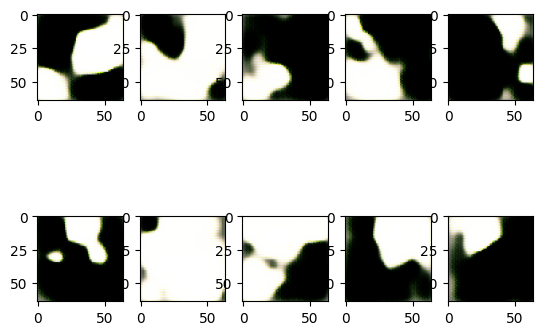

In [ ]:
from math import ceil
import matplotlib.pyplot as plt 

n_images = 10

cols = 5
rows = ceil( n_images/cols)

fig, axs = plt.subplots( rows, cols)

for row in range(rows):
  for col in range(cols):
      random_latent_vector = tf.random.normal(shape=(1, latent_dim))
      generated = gan.generator(random_latent_vector)
      generated *= 255
      generated = generated.numpy().squeeze()
      generated = array_to_img(generated)
      
      axs[row][col].imshow( generated)

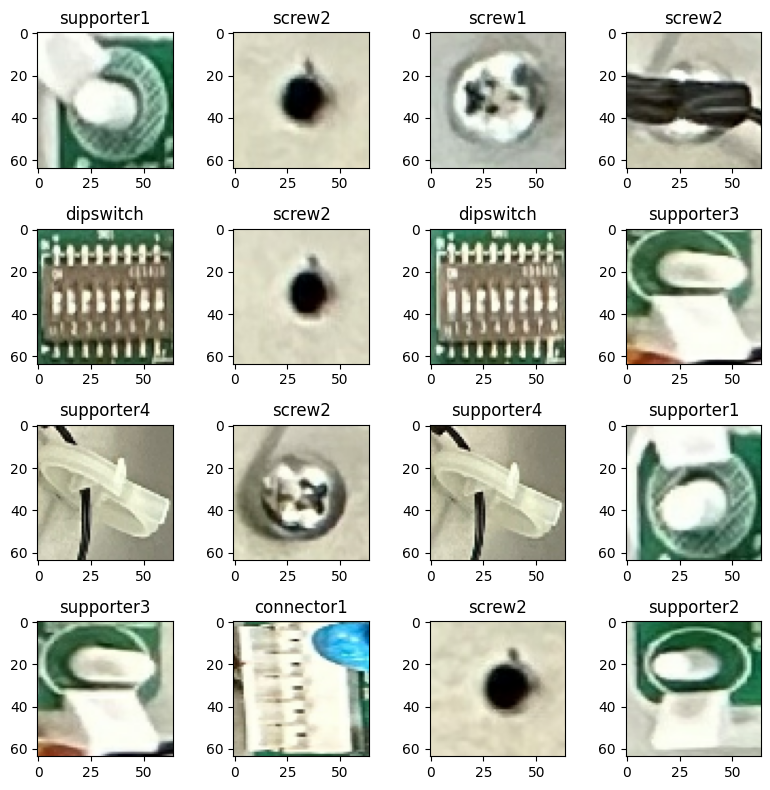

In [ ]:
import numpy as np

def get_class_name(y):
  names = ['connector1', 'connector2', 'dipswitch', 'multiscrew', 'screw1', 'screw2', 'supporter1', 'supporter2', 'supporter3', 'supporter4']
  idx = np.where(y == 1)
  return names[idx[0][0]]
  
transformations = [ 
      RandomFlip("horizontal"),
      RandomFlip("vertical"),
      RandomRotation(0.4, fill_mode='reflect'),
      RandomZoom( .5, .2),
      RandomBrightness( factor=0.9)
]

x_train_augmented = []
y_train_augmented = []

nb_data_to_generate = 64
nb_need_iters = int(nb_data_to_generate/batch_size)

for i in range(nb_need_iters):
  batch_images, batch_y = next(iter(dataset))
  for img, y in zip(batch_images, batch_y):
    transfo = random.choice( transformations)
    x_train_augmented.append( transfo(img))
    y_train_augmented.append( y)
    

dataset_rotated = tf.data.Dataset.from_tensor_slices(
    (tf.convert_to_tensor(x_train_augmented),
    tf.convert_to_tensor(y_train_augmented))
)

batch_images, batch_y = next(iter(dataset))
fig, axes = plt.subplots(4,4, figsize=(8,8))
for row in range(4):
  for col in range(4):
    axes[row][col].imshow( array_to_img(batch_images[row*4 + col]))
    axes[row][col].set_title( get_class_name( batch_y[row*4 + col]))
plt.tight_layout()
plt.show()


In [ ]:
print( next(iter(x_train)).shape)

(32, 64, 64, 3)


In [ ]:
from PIL import Image

for i in range(256):
  batch_images, batch_y = next(iter(dataset))
  for image, y in zip(batch_images, batch_y):
    np_arr = np.array(image, dtype=np.uint8)
    img = Image.fromarray(np_arr)
    img.save(f'drive/MyDrive/machinelearning/gan_result_rgb/TM-A_Chassis_Single/{get_class_name(y)}/{get_class_name(y)}_{i}.jpg')